<div class="markdown-google-sans">

# Zárthelyi dolgozat
</div>

- Másold le a dokumentumot a megszokott módon és nevezd át, úgy, hogy az tartalmazza a nevedet és a Neptun-kódodat (Vezetknév_Keresztnév-NEPTUNKÓD)!
- Miután átnevezted, oszd meg a dokumentumot velünk szerkesztési joggal! (az email-címeinket a táblán találod)


- Kérünk benneteket, hogy ahol csak lehetséges, legjobb tudomásotok szerint kommentezzétek fel a kódot, illetve válaszoljatok szövegesen is.
- A hangsúly azon van, ahogyan előállítjátok a kért adatokat, nem azok pontosságán, így ha valahol hibás predikációt ad a modell nem gond, (de lehetőség szerint ismerjétek fel, és írjátok oda, hogy mi lenne az elvárt viselkedés szerintetek).
- <u>Ezen felül, ha előre láthatóan ki fogtok futni az időből, akkor lehetőség szerint írjátok le szövegesen, mit csináltatok volna a maradék feladatokkal!</u>


- A zárthelyi megírásához használhattok bármilyen segédanyagot, kivéve egymást. **Se online, se offline!**


**Sok Sikert Kívánunk!**

---

# 1. feladat

Az https://github.com/rfarkas/student_data/raw/main/images/500faces.zip fájl arcképeket tartalmaz. Hajts végre **regressziós** gépi tanulási kísérletet arra nézve, hogy az életkor mennyire jól állapítható meg képek alapján! A fájlok nevének első `_` előtti része tartalmazza az igazi életkort. Használd a képek véletlenszerű 20%-át kiértékelő adatbázisnak.

Érdemes a képeket kisebbre átméretezni, esetleg szürkeárnyalossá konvertálni, hogy gyorsabban lehessen kísérletezni.


In [ ]:
#imports

import os
import urllib.request
import zipfile
import cv2 as cv #OpenCV
import pandas as pd
from sklearn.linear_model import SGDRegressor
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error # MSE
from sklearn.linear_model import LinearRegression, Ridge

from sklearn.metrics import mean_squared_error # MSE (RMSE végső gyökvonás nélkül)

!wget https://raw.githubusercontent.com/christiansafka/img2vec/master/img2vec_pytorch/img_to_vec.py

from img_to_vec import Img2Vec
img2vec = Img2Vec()

from PIL import Image # PIL típusú képformátumban várja az inputot az img2vec

import warnings
warnings.filterwarnings("ignore")

--2023-12-08 16:27:34--  https://raw.githubusercontent.com/christiansafka/img2vec/master/img2vec_pytorch/img_to_vec.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7947 (7.8K) [text/plain]
Saving to: ‘img_to_vec.py’

img_to_vec.py       100%[===================>]   7.76K  --.-KB/s    in 0s      

2023-12-08 16:27:34 (94.7 MB/s) - ‘img_to_vec.py’ saved [7947/7947]



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 64.4MB/s]


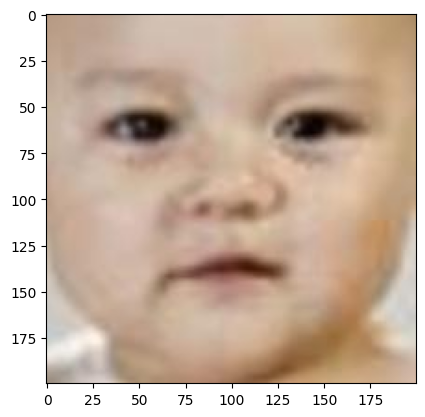

In [ ]:
#letöltjük a címkézett képfájlokat
url = 'https://github.com/rfarkas/student_data/raw/main/images/500faces.zip'
urllib.request.urlretrieve(url,'t.zip') #a t.zip a temporálisan notebookhoz rendelt tárhelyre kerül a Google felhőjében

#kitömörítjük a zip tartalmát
zipfile.ZipFile('t.zip').extractall('tmp_imgs')

image = cv.imread('tmp_imgs/1_0_0_20161219191041403.jpg.chip.jpg') # egy JPEG fájl a temporális könyvtárból
#ha meg akarjuk jeleníteni a képeket a notebookban
plt.imshow(image)
plt.imshow(cv.cvtColor(image,cv.COLOR_BGR2RGB))

# több módszer is van egyenméretezésre (például levágás), de most csak tömörítünk:
image_small = cv.resize(image,(32,32)) # 32 x 32 méretűre konvertáljuk a képet
# plt.imshow(cv.cvtColor(image_small,cv.COLOR_BGR2RGB))

rawImages = [] # a lista minden eleme egy eredeti kép
features = [] # a lista minden eleme egy kép pixelvektora
labels = [] # a lista minden eleme a kép címkéje ('cat' vagy 'dog')

for f in os.listdir('tmp_imgs'): # könyvtárbejárás
  image = cv.imread('tmp_imgs/'+f) # kép beolvasása
  label = f.split(os.path.sep)[-1].split("_")[0] # a fájlnév megadja most a címkét (vagy cat vagy dog az első '.' előtt fájlnév)

  #flatten a 3D tömbből 1D-t csinál (egymás után fűzi a sorokat)
  pixels = cv.resize(image,(32,32)).flatten() # egyenméretűre hozzuk a képeket! 32 x 32 x 3 = 3072 érték képenként

  rawImages.append(image)
  features.append(pixels)
  labels.append(label)

img = Image.open('tmp_imgs/1_0_0_20161219191041403.jpg.chip.jpg')
img2vec.get_vec(img)

# rawImage formátumunkból így tudunk PTL-t gyártani:
img = Image.fromarray(rawImages[0])
len(img2vec.get_vec(img))

# A képegyedeket most az img2vec beágyazással írjuk le (512 folytonos jellemző)
vecs = []
for img in rawImages:
  vecs.append( img2vec.get_vec( Image.fromarray(img) ))

trainFeatures = vecs[:81]
testFeatures  = vecs[81:]
trainLables = labels[:81]
testLables  = labels[81:]




In [ ]:
cls = SGDRegressor()
model = cls.fit(trainFeatures, trainLables)
prediction = model.predict(testFeatures)
print("Ilyen ügyes a betanított modellünk: ", mean_squared_error(prediction, testLables))

dummy = DummyRegressor(strategy='mean') # tanító adatbázis címkéinek átlaga lesz mindig a predikció
dummy.fit(trainFeatures, trainLables)
mean_squared_error(dummy.predict(testFeatures), testLables)

ValueError: ignored

In [ ]:
prediction

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
plt.plot(range(0,len(trainLables)), trainLables, c='grey', alpha=0.5)
testrange = range(len(trainLables)-1,len(trainLables)+len(testLables)-1)
plt.plot(testrange, testLables, c='c', marker='o')
plt.plot(testrange, prediction, c='r', marker='o')
ax.legend(['múlt', 'jövőbeli tényleges', 'predikció'])
plt.show()

# 2. feladat
Próbálj ki egy másik regressziós algoritmust is az 1. feladatra. Mindkét módszernek hangold be a meta-paraméterit. (bónus feladat: a meta-paraméter értékekre a túltanási ábra kirajzolása)

A végén szövegként írd le, hogy a két algoritmus közül melyik a jobb!


In [ ]:
reg = LinearRegression() # lineáris gép regresszióra
reg.fit(trainFeatures, trainLables)
prediction = reg.predict(testFeatures)

mean_squared_error(prediction, testLables)

379.1249811709607

In [ ]:
test = []
train = []

for i in range(2, 100, 10):
  reg = Ridge(alpha = i)
 # lineáris gép regresszióra
  reg.fit(trainFeatures, trainLables)
  prediction = reg.predict(testFeatures)
  test.append(prediction)
  print(mean_squared_error(prediction, testLables))
  prediction = reg.predict(trainFeatures)
  train.append(prediction)

# plusz a másik algoritmus train és test predikciója is
# ábra kirajzolása

361.4940357103832
321.0851461660327
304.41109740709453
295.2897212948527
289.6527142137366
285.94868421064916
283.4447463422084
281.7449504221658
280.6144884407866
279.904175119176


A két algoritmus közül nekem a Lineáris regresszió jobban működött alap paraméterekkel.

# 3. feladat
Klaszterezd a képeket minden klaszterből jeleníts meg 3-3db képet, hogy kapjunk egy benyomást, hogy mik kerültek egy klaszterbe.